# Facility-by-Facility Comparison: TLO Model vs ANC Disruption Data

Matches TLO model-estimated disruption rates to ANC-derived disruption probabilities
at the individual facility level via `RealFacility_ID`.

**Requires:** `write_to_hsi_log` in `healthsystem.py` logs `RealFacility_ID` as the key
in `_hsi_event_counts_by_facility_monthly` (i.e. keys are `RealFacility_ID:treatment_id`).
No integer Facility_ID → RealFacility_ID mapping is needed.

**Structure:**
1. Configuration & imports
2. Load ANC disruption data (ground truth)
3. Helper extraction functions
4. Extract baseline denominator & disrupted counts
5. Compute per-facility disruption fractions & merge with ANC
6. Scatter: TLO model output vs ANC input
7. Facility-level time series panels
8. Summary statistics & residual diagnostics

In [7]:
# ══════════════════════════════════════════════════════════════════════════════
#  0.  CONFIGURATION  — edit paths here
# ══════════════════════════════════════════════════════════════════════════════
from pathlib import Path

# TLO simulation output folders
results_folder_climate  = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-20T161931Z')

# ANC / climate data files
SSP     = 'ssp245'
MODEL   = 'mean'
SERVICE = 'ANC'

ANC_PREDICTIONS_CSV = Path(f'/Users/rem76/Desktop/Climate_Change_Health/Data/weather_predictions_with_X_{SSP}_{MODEL}_{SERVICE}.csv')
DISRUPTIONS_CSV     = Path(f'/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/ResourceFile_Precipitation_Disruptions_{SSP}_{MODEL}.csv')

# Where to write figures
OUTPUT_DIR = Path('/Users/rem76/Desktop/Climate_Change_Health')
OUTPUT_DIR.mkdir(exist_ok=True)

# Analysis window
min_year         = 2025
max_year         = 2036   # exclusive
spacing_of_years = 1

# Scenarios
scenario_names       = ['Baseline', 'Best Case', 'Worst Case']
scenarios_of_interest = [1, 2, 3]   # draw 0 = no-disruption run, skip it

# District name harmonisation
DISTRICT_MERGE = {
    'Mzimba North': 'Mzimba', 'Mzimba South': 'Mzimba',
    'Blantyre City': 'Blantyre', 'Zomba City': 'Zomba',
    'Lilongwe City': 'Lilongwe',
}

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
#  1.  IMPORTS
# ══════════════════════════════════════════════════════════════════════════════
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy import stats as scipy_stats

from tlo import Date
from tlo.analysis.utils import extract_results, summarize

target_year_sequence = range(min_year, max_year, spacing_of_years)
TARGET_YEARS         = list(target_year_sequence)

print(f'Analysis years : {min_year} – {max_year - 1}  ({len(TARGET_YEARS)} years)')
print(f'Scenarios      : {scenario_names}')

Analysis years : 2025 – 2035  (11 years)
Scenarios      : ['Baseline', 'Best Case', 'Worst Case']


## 2. Load ANC disruption data

In [9]:
# ── ANC resource file: disruption probability by facility / year / month ──────
disruptions_df = pd.read_csv(DISRUPTIONS_CSV)

# Annual mean disruption probability per facility (average across 12 months)
anc_annual = (
    disruptions_df
    .groupby(['RealFacility_ID', 'year'])['disruption']
    .mean()
    .reset_index()
    .rename(columns={'disruption': 'anc_prob', 'year': 'Year'})
)
anc_annual['anc_pct'] = anc_annual['anc_prob'] * 100
anc_annual = anc_annual[anc_annual['Year'].between(min_year, max_year - 1)]

print(f'ANC data: {anc_annual["RealFacility_ID"].nunique()} unique facilities, '
      f'{anc_annual["Year"].nunique()} years')
print(f'  Mean annual disruption probability: {anc_annual["anc_pct"].mean():.2f}%')
anc_annual.head()

ANC data: 328 unique facilities, 11 years
  Mean annual disruption probability: 0.56%


,RealFacility_ID,Year,anc_prob,anc_pct
0,Area 30 Police Clinic,2025,0.006528,0.652783
1,Area 30 Police Clinic,2026,0.003169,0.316924
2,Area 30 Police Clinic,2027,0.002392,0.239246
3,Area 30 Police Clinic,2028,0.010278,1.027783
4,Area 30 Police Clinic,2029,0.010013,1.001276


In [10]:
# ── Facility metadata from ANC predictions file ───────────────────────────────
anc_pred = pd.read_csv(ANC_PREDICTIONS_CSV)
anc_pred = anc_pred.rename(columns={'Facility_ID': 'RealFacility_ID'})
anc_pred['District'] = anc_pred['District'].replace(DISTRICT_MERGE)

fac_meta = (
    anc_pred[['RealFacility_ID', 'District', 'Facility_Type']]
    .drop_duplicates(subset='RealFacility_ID')
    .set_index('RealFacility_ID')
)
print(f'Facility metadata loaded: {len(fac_meta)} facilities')

Facility metadata loaded: 329 facilities


## 3. Helper extraction functions

Because `write_to_hsi_log` now keys `_hsi_event_counts_by_facility_monthly` on
`RealFacility_ID:treatment_id` (not integer `Facility_ID`), no ID mapping is needed.
The denominator and numerator are both naturally in `RealFacility_ID` space.

In [15]:
def get_hsi_counts_by_facility_monthly(_df):
    """Sum HSI event counts by RealFacility_ID within TARGET_PERIOD.
    Keys in the counts dict are now 'RealFacility_ID:treatment_id'.
    """
    _df['date'] = pd.to_datetime(_df['date'])
    _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
    if len(_df) == 0:
        return pd.Series(dtype=int)
    facility_totals = {}
    for _, row in _df.iterrows():
        for key, value in row['counts'].items():
            if ':' in str(key):
                real_fac_id = key.split(':', 1)[0]
                facility_totals[real_fac_id] = facility_totals.get(real_fac_id, 0) + value
    return pd.Series(facility_totals)


def get_num_treatments_by_real_facility_delayed(_df):
    """Count delayed HSI events grouped by RealFacility_ID."""
    print(_df)
    _df['date'] = pd.to_datetime(_df['date'])
    _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
    _df = _df[_df['RealFacility_ID'].notna() & (_df['RealFacility_ID'] != 'unknown')]
    if len(_df) == 0:
        return pd.Series(dtype=int)
    return _df.groupby('RealFacility_ID').size()


def get_num_treatments_by_real_facility_cancelled(_df):
    """Count cancelled HSI events grouped by RealFacility_ID."""
    _df['date'] = pd.to_datetime(_df['date'])
    _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
    _df = _df[_df['RealFacility_ID'].notna() & (_df['RealFacility_ID'] != 'unknown')]
    if len(_df) == 0:
        return pd.Series(dtype=int)
    return _df.groupby('RealFacility_ID').size()

## 4. Extract baseline denominator & disrupted counts

In [18]:
# Storage
all_scenarios_appointment_delayed_mean   = {}
all_scenarios_appointment_cancelled_mean = {}

# ── Baseline denominator: total HSI events by RealFacility_ID ─────────────────
baseline_hsi_by_facility = {}

for target_year in target_year_sequence:
    TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))
    print(f'  baseline year {target_year}', end='\r')

    hsi_by_facility = summarize(extract_results(
        results_folder_baseline,
        module='tlo.methods.healthsystem.summary',
        key='hsi_event_counts_by_facility_monthly',
        custom_generate_series=get_hsi_counts_by_facility_monthly,
        do_scaling=False
    ), only_mean=True, collapse_columns=False)[0]

    # Index is already RealFacility_ID strings — no mapping needed
    hsi_by_facility.index.name = 'RealFacility_ID'
    hsi_by_facility = hsi_by_facility.groupby(level=0).sum()  # collapse any duplicates
    baseline_hsi_by_facility[target_year] = hsi_by_facility

print(f'\nBaseline denominator ready. Example year {min_year}: '
      f'{len(baseline_hsi_by_facility[min_year])} facilities')

# ── Numerator: delayed & cancelled counts by RealFacility_ID, per draw ────────
for draw in scenarios_of_interest:
    print(f'draw {draw}')
    all_years_data_delayed_mean   = {}
    all_years_data_cancelled_mean = {}

    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Extract all draws at once — draw 0 will be NaN/0, draws 1+ have disruptions
        all_draws_delayed = summarize(extract_results(
            results_folder_climate,
            module='tlo.methods.healthsystem.summary',
            key='Weather_delayed_HSI_Event_full_info',
            custom_generate_series=get_num_treatments_by_real_facility_delayed,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)

        all_draws_cancelled = summarize(extract_results(
            results_folder_climate,
            module='tlo.methods.healthsystem.summary',
            key='Weather_cancelled_HSI_Event_full_info',
            custom_generate_series=get_num_treatments_by_real_facility_cancelled,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)

        # Index by draw; fill NaN (draw 0 / no-event draws) with 0
        num_delayed_by_facility   = all_draws_delayed[draw].fillna(0)
        num_cancelled_by_facility = all_draws_cancelled[draw].fillna(0)

        baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(
            num_delayed_by_facility, fill_value=0)
        delayed_proportions = delayed_aligned / baseline_aligned

        baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(
            num_cancelled_by_facility, fill_value=0)
        cancelled_proportions = cancelled_aligned / baseline_aligned

        all_years_data_delayed_mean[target_year]   = delayed_proportions
        all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw]   = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean

print('Extraction complete.')

  baseline year 2035
Baseline denominator ready. Example year 2025: 99 facilities
draw 1
           date                                      Event_Name  Facility_ID  \
0    2025-01-01                   HSI_GenericEmergencyFirstAppt           27   
1    2025-01-01                          HSI_Epilepsy_Follow_Up           31   
2    2025-01-01                          HSI_Epilepsy_Follow_Up           75   
3    2025-01-01                          HSI_Epilepsy_Follow_Up            3   
4    2025-01-01                   HSI_GenericEmergencyFirstAppt          103   
...         ...                                             ...          ...   
3251 2041-01-09            HSI_Contraception_FamilyPlanningAppt           65   
3252 2041-01-11            HSI_Contraception_FamilyPlanningAppt           67   
3253 2041-01-11  HSI_CardioMetabolicDisorders_Refill_Medication           63   
3254 2041-01-11            HSI_Contraception_FamilyPlanningAppt           67   
3255 2041-01-11     HSI_CardioM

ValueError: All objects passed were None

## 5. Compute per-facility disruption fractions & merge with ANC

In [ ]:
# ── Build summary table: mean/median/IQR across draws per (facility, year) ────
summary_rows = []

for target_year in target_year_sequence:
    # Stack all draws for this year into a DataFrame (index=RealFacility_ID, cols=draws)
    total_by_draw = {}
    for draw in scenarios_of_interest:
        delayed   = all_scenarios_appointment_delayed_mean[draw][target_year]
        cancelled = all_scenarios_appointment_cancelled_mean[draw][target_year]
        total_by_draw[draw] = (delayed + cancelled).fillna(0)

    df = pd.DataFrame(total_by_draw)  # shape (n_facilities, n_draws)

    s = pd.DataFrame({
        'mean':   df.mean(axis=1),
        'median': df.median(axis=1),
        'p25':    df.quantile(0.25, axis=1),
        'p75':    df.quantile(0.75, axis=1),
        'p05':    df.quantile(0.05, axis=1),
        'p95':    df.quantile(0.95, axis=1),
    })
    s.index.name = 'RealFacility_ID'
    s = s.reset_index()
    s['Year'] = target_year
    summary_rows.append(s)

tlo_summary = pd.concat(summary_rows, ignore_index=True)
# Convert fractions to %
for col in ['mean', 'median', 'p25', 'p75', 'p05', 'p95']:
    tlo_summary[col] *= 100

print(f'TLO summary: {tlo_summary["RealFacility_ID"].nunique()} facilities × '
      f'{tlo_summary["Year"].nunique()} years')

In [ ]:
# ── Merge with ANC data and facility metadata ──────────────────────────────────
comparison = (
    tlo_summary
    .merge(anc_annual, on=['RealFacility_ID', 'Year'], how='inner')
    .merge(fac_meta.reset_index(), on='RealFacility_ID', how='left')
    .dropna(subset=['mean', 'anc_pct'])
)

n_fac   = comparison['RealFacility_ID'].nunique()
n_years = comparison['Year'].nunique()
print(f'Matched: {n_fac} facilities × {n_years} years = {len(comparison)} rows')

# Diagnostic: how many ANC facilities are missing from TLO outputs?
tlo_facs = set(tlo_summary['RealFacility_ID'])
anc_facs = set(anc_annual['RealFacility_ID'])
missing  = anc_facs - tlo_facs
print(f'ANC facilities not found in TLO outputs: {len(missing)}')
if missing:
    print('  First 10:', sorted(missing)[:10])

comparison[['RealFacility_ID', 'Year', 'mean', 'p25', 'p75', 'anc_pct', 'District', 'Facility_Type']].head(8)

## 6. Scatter: TLO model output vs ANC input

NameError: name 'comparison' is not defined

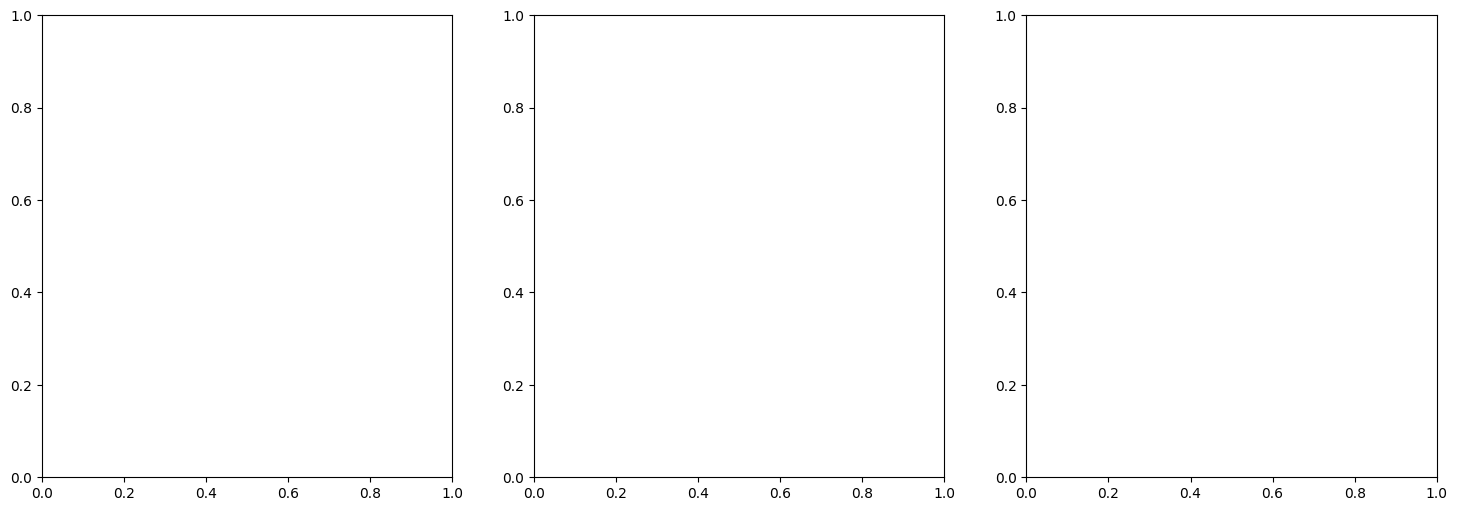

In [19]:
def _broad_type(t):
    if pd.isna(t): return 'Other'
    t = t.lower()
    if 'hospital' in t: return 'Hospital'
    if 'health centre' in t or 'health center' in t: return 'Health Centre'
    if 'health post' in t or 'dispensary' in t or 'village' in t: return 'Health Post'
    return 'Other'


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

years_in_data = sorted(comparison['Year'].unique())
cmap      = plt.cm.plasma
norm      = Normalize(vmin=min(years_in_data), vmax=max(years_in_data))
axis_max  = max(comparison[['mean', 'anc_pct']].max()) * 1.1
xs        = np.linspace(0, axis_max, 100)

# ─── Panel A: all facility-years, coloured by year ───────────────────────────
ax = axes[0]
for year in years_in_data:
    sub = comparison[comparison['Year'] == year].dropna(subset=['mean', 'anc_pct'])
    ax.scatter(sub['anc_pct'], sub['mean'],
               c=[cmap(norm(year))] * len(sub), alpha=0.4, s=12, linewidths=0)

ax.plot([0, axis_max], [0, axis_max], 'k--', lw=1, alpha=0.5, label='1:1')
sub_all = comparison.dropna(subset=['mean', 'anc_pct'])
slope, intercept, r, p, _ = scipy_stats.linregress(sub_all['anc_pct'], sub_all['mean'])
ax.plot(xs, intercept + slope * xs, 'r-', lw=1.8,
        label=f'OLS  slope={slope:.2f}  R²={r**2:.3f}')
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='Year', shrink=0.85)
ax.set_xlabel('ANC disruption probability (%)', fontsize=10)
ax.set_ylabel('TLO disruption rate (%) [mean across draws]', fontsize=10)
ax.set_title('A) All facility-years\n(coloured by year)', fontsize=11)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, ls=':')

# ─── Panel B: time-averaged per facility, coloured by type ───────────────────
ax = axes[1]
fac_avg = (
    comparison
    .groupby('RealFacility_ID')[['mean', 'p25', 'p75', 'anc_pct', 'Facility_Type']]
    .agg({'mean': 'mean', 'p25': 'mean', 'p75': 'mean',
          'anc_pct': 'mean', 'Facility_Type': 'first'})
    .reset_index().dropna()
)
fac_avg['broad_type'] = fac_avg['Facility_Type'].apply(_broad_type)

type_colour = {'Health Post': '#1f77b4', 'Health Centre': '#ff7f0e',
               'Hospital': '#2ca02c', 'Other': '#9467bd'}
for bt, grp in fac_avg.groupby('broad_type'):
    ax.errorbar(grp['anc_pct'], grp['mean'],
                yerr=[grp['mean'] - grp['p25'], grp['p75'] - grp['mean']],
                fmt='o', alpha=0.5, markersize=5, elinewidth=0.6, capsize=0,
                color=type_colour.get(bt, '#9467bd'), label=bt)

ax.plot([0, axis_max], [0, axis_max], 'k--', lw=1, alpha=0.5)
slope2, intercept2, r2, p2, _ = scipy_stats.linregress(fac_avg['anc_pct'], fac_avg['mean'])
ax.plot(xs, intercept2 + slope2 * xs, 'r-', lw=1.8,
        label=f'OLS  slope={slope2:.2f}  R²={r2**2:.3f}')
ax.set_xlabel('ANC disruption probability (%) [time-avg]', fontsize=10)
ax.set_ylabel('TLO disruption rate (%) [time-avg]', fontsize=10)
ax.set_title('B) Per-facility averages\n(IQR bars, coloured by type)', fontsize=11)
ax.legend(fontsize=7, loc='upper left')
ax.grid(True, alpha=0.3, ls=':')

# ─── Panel C: residuals ───────────────────────────────────────────────────────
ax = axes[2]
sub_all = comparison.dropna(subset=['mean', 'anc_pct']).copy()
sub_all['residual'] = sub_all['mean'] - sub_all['anc_pct']
ax.scatter(sub_all['anc_pct'], sub_all['residual'],
           c=[cmap(norm(y)) for y in sub_all['Year']],
           alpha=0.35, s=12, linewidths=0)
ax.axhline(0, color='k', lw=1, ls='--', alpha=0.5, label='Zero residual')
ax.axhline(sub_all['residual'].mean(), color='r', lw=1.5,
           label=f'Mean = {sub_all["residual"].mean():.2f}%')
bin_edges  = np.percentile(sub_all['anc_pct'], np.arange(0, 101, 5))
sub_all['anc_bin'] = pd.cut(sub_all['anc_pct'], bins=bin_edges)
bin_median  = sub_all.groupby('anc_bin')['residual'].median()
bin_centres = [i.mid for i in bin_median.index]
ax.plot(bin_centres, bin_median.values, 'orange', lw=2, zorder=5, label='Binned median')
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='Year', shrink=0.85)
ax.set_xlabel('ANC disruption probability (%)', fontsize=10)
ax.set_ylabel('TLO − ANC (pp residual)', fontsize=10)
ax.set_title('C) Residuals\n(TLO model minus ANC input)', fontsize=11)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, ls=':')

fig.suptitle(
    f'Facility-level comparison: TLO model vs ANC disruption data\n'
    f'{n_fac} facilities | {len(scenarios_of_interest)} draws | {SSP.upper()} {MODEL} | {min_year}–{max_year-1}',
    fontsize=12, fontweight='bold', y=1.01
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'facility_comparison_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'OLS all facility-years:  slope={slope:.3f}  R²={r**2:.3f}  p={p:.3g}')
print(f'OLS time-averaged facs:  slope={slope2:.3f}  R²={r2**2:.3f}  p={p2:.3g}')
print(f'Mean residual (TLO−ANC): {sub_all["residual"].mean():.2f}%')

## 7. Facility-level time series panels

Top 20 and bottom 20 facilities by mean ANC disruption probability.
Blue = TLO model mean ± IQR. Purple = ANC disruption probability.

In [ ]:
fac_anc_rank = (
    anc_annual.groupby('RealFacility_ID')['anc_pct'].mean().sort_values(ascending=False)
)
# Keep only facilities present in TLO outputs
fac_anc_rank = fac_anc_rank[fac_anc_rank.index.isin(set(tlo_summary['RealFacility_ID']))]

N_PANEL     = 20
top_facs    = fac_anc_rank.head(N_PANEL).index.tolist()
bottom_facs = fac_anc_rank.tail(N_PANEL).index.tolist()
panel_facs  = top_facs + bottom_facs

print(f'Top    {N_PANEL}: mean ANC = {fac_anc_rank.head(N_PANEL).mean():.2f}%')
print(f'Bottom {N_PANEL}: mean ANC = {fac_anc_rank.tail(N_PANEL).mean():.2f}%')

In [ ]:
# Pre-build time series arrays per facility
DATE_INDEX = pd.to_datetime([f'{y}-07-01' for y in TARGET_YEARS])
fac_ts = {}

for fac in panel_facs:
    sub = tlo_summary[tlo_summary['RealFacility_ID'] == fac].set_index('Year')
    fac_ts[fac] = {
        'median': np.array([sub.loc[y, 'median'] if y in sub.index else np.nan for y in TARGET_YEARS]),
        'p25':    np.array([sub.loc[y, 'p25']    if y in sub.index else np.nan for y in TARGET_YEARS]),
        'p75':    np.array([sub.loc[y, 'p75']    if y in sub.index else np.nan for y in TARGET_YEARS]),
    }

print('Time series arrays built.')

In [ ]:
n_cols = 8
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(3.0 * n_cols, 2.5 * n_rows),
                         sharex=True, squeeze=True)
axes_flat = axes.flatten()

for i, fac in enumerate(panel_facs):
    ax    = axes_flat[i]
    group = 'Top' if i < N_PANEL else 'Bottom'
    title_colour = '#8B0000' if group == 'Top' else '#00008B'

    ts = fac_ts[fac]
    ax.fill_between(DATE_INDEX, ts['p25'], ts['p75'], color='#4169E1', alpha=0.25)
    ax.plot(DATE_INDEX, ts['median'], color='#4169E1', lw=1.5, label='TLO median')

    anc_sub = anc_annual[anc_annual['RealFacility_ID'] == fac].sort_values('Year')
    if len(anc_sub) > 0:
        anc_dates = pd.to_datetime([f'{y}-07-01' for y in anc_sub['Year']])
        ax.plot(anc_dates, anc_sub['anc_pct'], color='purple', lw=1.5, label='ANC data')
    ax.axhline(fac_anc_rank.get(fac, np.nan), color='purple', lw=0.7, ls=':', alpha=0.5)

    short = (fac[:22] + '…') if len(fac) > 22 else fac
    ax.set_title(f'{short}\n({group}, ANC≈{fac_anc_rank.get(fac, 0):.1f}%)',
                 fontsize=5.5, pad=2, color=title_colour, fontweight='bold')
    ax.grid(True, alpha=0.2, ls=':')
    ax.tick_params(labelsize=5)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=5)
    if i == 0:
        ax.legend(fontsize=5, loc='upper left', framealpha=0.7)

for j in range(len(panel_facs), len(axes_flat)):
    axes_flat[j].set_visible(False)

fig.supylabel('% appointments disrupted', fontsize=9, x=0.0)
fig.suptitle(
    f'Facility time series — TLO model (blue, IQR band) vs ANC data (purple)\n'
    f'Top {N_PANEL} (red) & {N_PANEL} lowest-disrupted (blue) by ANC estimate',
    fontsize=11, fontweight='bold'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'facility_timeseries_top_bottom.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary statistics & residual diagnostics

In [ ]:
comp = comparison.dropna(subset=['mean', 'anc_pct']).copy()
comp['residual']     = comp['mean'] - comp['anc_pct']
comp['abs_residual'] = comp['residual'].abs()
comp['broad_type']   = comp['Facility_Type'].apply(_broad_type)

print('═' * 55)
print(f'  Facilities matched:          {comp["RealFacility_ID"].nunique():>6}')
print(f'  Facility-year rows:          {len(comp):>6}')
print(f'  Mean ANC disruption:         {comp["anc_pct"].mean():>6.2f}%')
print(f'  Mean TLO disruption:         {comp["mean"].mean():>6.2f}%')
print(f'  Mean residual (TLO − ANC):   {comp["residual"].mean():>6.2f}%')
print(f'  Median |residual|:            {comp["abs_residual"].median():>5.2f}%')
print(f'  Pearson r:                   {comp["mean"].corr(comp["anc_pct"]):>6.3f}')
print(f'  Spearman ρ:                  {comp["mean"].corr(comp["anc_pct"], method="spearman"):>6.3f}')
print('═' * 55)

by_type = (
    comp.groupby('broad_type')
    .agg(n_fac=('RealFacility_ID','nunique'), mean_anc=('anc_pct','mean'),
         mean_tlo=('mean','mean'), mean_resid=('residual','mean'),
         median_resid=('residual','median'))
    .round(2)
)
print('\nBy facility type:')
print(by_type.to_string())

by_year = (
    comp.groupby('Year')
    .agg(mean_anc=('anc_pct','mean'), mean_tlo=('mean','mean'), mean_resid=('residual','mean'))
    .round(2)
)
print('\nBy year:')
print(by_year.to_string())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
groups_ordered = ['Health Post', 'Health Centre', 'Hospital', 'Other']
data_for_box   = [comp.loc[comp['broad_type'] == g, 'residual'].dropna() for g in groups_ordered]
bp = ax.boxplot(data_for_box, labels=groups_ordered, patch_artist=True,
                medianprops=dict(color='black', lw=2))
for patch, colour in zip(bp['boxes'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']):
    patch.set_facecolor(colour); patch.set_alpha(0.6)
ax.axhline(0, color='k', lw=1, ls='--', alpha=0.5)
ax.set_ylabel('TLO − ANC (percentage points)', fontsize=10)
ax.set_title('Residuals by facility type', fontsize=11)
ax.grid(True, alpha=0.3, ls=':')

ax = axes[1]
mean_resid_year = by_year['mean_resid']
ax.bar(mean_resid_year.index, mean_resid_year.values,
       color=['#d62728' if v > 0 else '#1f77b4' for v in mean_resid_year.values],
       alpha=0.75, edgecolor='white', linewidth=0.5)
ax.axhline(0, color='k', lw=1)
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Mean residual (TLO − ANC, pp)', fontsize=10)
ax.set_title('Mean residual over time\n(red = over-estimates, blue = under-estimates)', fontsize=11)
ax.grid(True, alpha=0.3, ls=':', axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.suptitle('Residual analysis: TLO model vs ANC disruption data', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'facility_residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
export_cols = ['RealFacility_ID', 'Year', 'District', 'Facility_Type', 'broad_type',
               'mean', 'median', 'p25', 'p75', 'p05', 'p95',
               'anc_pct', 'residual', 'abs_residual']
export_df = comp[export_cols].round(4)
export_path = OUTPUT_DIR / 'facility_level_comparison_table.csv'
export_df.to_csv(export_path, index=False)
print(f'Saved → {export_path}')
export_df.head()